In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
K = keras.backend

from sklearn.model_selection import train_test_split

## Загрузим эмбеддинги

In [6]:
class Vocab(object):
    def __init__(self):
        self.rev_vocabulary_mapping = []
        self.vocabulary_mapping = {}
        self.embeddings = None
    
    def unvectorize(self, ids):
        return ' '.join([self.rev_vocabulary_mapping[i] for i in ids])
    
    def vectorize(self, tokens):
        return [self.vocabulary_mapping.get(w, self.vocabulary_mapping['<UNK>']) for w in tokens]
    
    def load_embeddings(self, filename, embedding_size=50, cut_at=400000):
        # список векторов
        embeddings_list = []
        # словарь слово-индекс
        self.vocabulary_mapping = {'<PAD>': 0} # занесём ключ соотетствующий отступу
        self.rev_vocabulary_mapping.append('<PAD>')
        pad = np.zeros(embedding_size) # создадим вектор для PAD
        embeddings_list.append(pad)

        with open(filename,encoding='utf8') as glove_file: 
            i = 1
            for line in glove_file:
                fields = line.split()
                token = fields[0]
                vector = np.array(list(map(float, fields[1:])))
                
                embeddings_list.append(vector)
                self.vocabulary_mapping[token] = i
                self.rev_vocabulary_mapping.append(token)
                i += 1
                if i >= cut_at:
                    break
                    
        self.vocabulary_mapping['<UNK>'] = len(embeddings_list)
        self.rev_vocabulary_mapping.append('<UNK>')
        unk = np.mean(embeddings_list[1:], axis=0) # считаем средний вектор
        embeddings_list.append(unk)

        self.embeddings = np.array(embeddings_list)
                
        print(f'Loaded {self.embeddings.shape} embeddings')        

In [7]:
vocab = Vocab()

In [8]:
vocab.load_embeddings('glove/glove.6B.50d.txt')

Loaded (400001, 50) embeddings


## Загрузим ATIS

In [9]:
def load_csv(filename):
    results = []
    with open(filename) as f:
        for l in f:
            results.append(l.strip())
            
    return results

Загрузим "словари" сущностей, классов и вокабуляр

In [11]:
slots = load_csv('data/atis.dict.slots.csv')
intents = load_csv('data/atis.dict.intent.csv')
atis_vocab = load_csv('data/atis.dict.vocab.csv')

Загрузим тренировочные данные

In [12]:
atis_train_queries = load_csv('data/atis.train.query.csv')
atis_train_intents = load_csv('data/atis.train.intent.csv')
atis_train_slots = load_csv('data/atis.train.slots.csv')

In [13]:
atis_train_queries = [[int(index) for index in line.split()] for line in atis_train_queries]
atis_train_intents = [int(index) for index in atis_train_intents]
atis_train_slots = [[int(index) for index in line.split()] for line in atis_train_slots]

Взглянем на данные

In [14]:
[' '.join([atis_vocab[i] for i in line]) for line in atis_train_queries]

['BOS i want to fly from boston at 838 am and arrive in denver at 1110 in the morning EOS',
 'BOS what flights are available from pittsburgh to baltimore on thursday morning EOS',
 'BOS what is the arrival time in san francisco for the 755 am flight leaving washington EOS',
 'BOS cheapest airfare from tacoma to orlando EOS',
 'BOS round trip fares from pittsburgh to philadelphia under 1000 dollars EOS',
 'BOS i need a flight tomorrow from columbus to minneapolis EOS',
 'BOS what kind of aircraft is used on a flight from cleveland to dallas EOS',
 'BOS show me the flights from pittsburgh to los angeles on thursday EOS',
 'BOS all flights from boston to washington EOS',
 'BOS what kind of ground transportation is available in denver EOS',
 'BOS show me the flights from dallas to san francisco EOS',
 'BOS show me the flights from san diego to newark by way of houston EOS',
 "BOS what 's the airport at orlando EOS",
 'BOS what is the cheapest flight from boston to bwi EOS',
 'BOS all fligh

In [15]:
atis_train_queries_w = [[atis_vocab[i] for i in line] for line in atis_train_queries]

In [16]:
train_sent = [vocab.vectorize(tokens[1:-1]) for tokens in atis_train_queries_w]
train_slots = [i[1:-1] for i in atis_train_slots]

In [17]:
train_labels = atis_train_intents

Не забудьте, что есть ещё и тестовый набор данных. На нём нужно будет посчитать итоговую точность для каждой из задач

## Собираем модель для классификации

In [18]:
def build_classification_model(embeddings):
    # Точка входа в граф задаётся при помощи специальных тензоров типа Input
    # Первая координата соответсвует длине текста, так как тексты в датасете имеют разную длину
    # значение считается переменным
    text_input = keras.layers.Input(shape=(None,), dtype='int32')
    
    # Создаём специальный слой для работы с embedding, 
    # Его функция -- заменять индентификатор вектором из Glove
    # Указываем trainable = False, чтобы векторы embedding'ов не изменялись в процессе обучения
    embedding_layer = keras.layers.Embedding(input_dim = embeddings.shape[0], 
                                       output_dim = embeddings.shape[1], 
                                       weights=[embeddings],
                                       trainable = False)
    
    x = embedding_layer(text_input)
    
    # Создаём рекуррентную ячейку
    # Первый параметр отвечает за размер внутреннего состояния (памяти ячейки)
    # По умолчанию такой слой возвращает только последнее состояние (см. картинку),
    # Если мы хотим получить состояния на каждом шаге необходимо указать return_sequences = True
    x = keras.layers.LSTM(128, recurrent_dropout=0.25)(x)

    # Полученный результат направляем в полносвязный слой, который будет осуществлять классификацию
    output = keras.layers.Dense(26, activation='softmax')(x)
    
    model = keras.models.Model(inputs=[text_input], outputs=[output], name = 'LSTM_classifier')
    
    return model

In [19]:
keras.backend.clear_session()
model = build_classification_model(vocab.embeddings)

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 50)          20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               91648     
_________________________________________________________________
dense (Dense)                (None, 26)                3354      
Total params: 20,095,052
Trainable params: 95,002
Non-trainable params: 20,000,050
_________________________________________________________________


In [21]:
#  Для оптимизации будем использовать Adam 
adam = keras.optimizers.Adam(lr=0.0001)

#Перед испльзованием модель необходимо скомпилировать
model.compile(adam, keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

Разобьём датасет на три части

In [22]:
x_train, x_val, y_train, y_val = train_test_split(train_sent, train_labels, test_size=0.1)

Почти всё готово, чтобы начать обучение. Но так, как все предлдожения разной длины мы не можем конвертировать x в тензор, нам необходимо выровнять длину. Для этого мы воспользуемся специальной функцией pad_sequences(), доступной в keras. Недостающие элементы будут заполнены специальным символом PAD

Но нам не хотелось бы увеличивать все элементы в датасете по размеру максимального. По этогому будем генерировать батчи сами и применять pad_sequences к ним независимо

In [23]:
def generate_batches(x, y, batch_size=64):
    i = 0
    while True:
        i = i % len(x)
        yield keras.preprocessing.sequence.pad_sequences(x[i:i+batch_size]), y[i:i+batch_size]
        i += batch_size

In [24]:
train_generator = generate_batches(x_train, y_train)
val_generator = generate_batches(x_val, y_val)



Теперь обучим нашу модель

In [25]:
cbs = [
    keras.callbacks.ModelCheckpoint('models/LSTM/{epoch:02d}-{val_loss:.4f}.h5', save_best_only=True),
    keras.callbacks.TensorBoard(log_dir='models/LSTM/'),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, verbose=1, min_lr=0.00001)
]


model.fit_generator(generator= train_generator, 
                    validation_data = val_generator, 
                    validation_steps= 64,
                    steps_per_epoch=256,
                    epochs=5,
                    callbacks=cbs)

Epoch 1/5
256/256 [==============================] - 32s 126ms/step - loss: 1.4208 - acc: 0.7277 - val_loss: 1.0751 - val_acc: 0.7180
Epoch 2/5
256/256 [==============================] - 29s 112ms/step - loss: 0.8568 - acc: 0.7787 - val_loss: 0.8105 - val_acc: 0.8036
Epoch 3/5
256/256 [==============================] - 26s 102ms/step - loss: 0.6497 - acc: 0.8497 - val_loss: 0.5946 - val_acc: 0.8674
Epoch 4/5
256/256 [==============================] - 26s 103ms/step - loss: 0.5128 - acc: 0.8768 - val_loss: 0.4816 - val_acc: 0.8766
Epoch 5/5
256/256 [==============================] - 27s 107ms/step - loss: 0.4393 - acc: 0.8915 - val_loss: 0.4182 - val_acc: 0.8918


## Самостоятельная работа

Необходимо построить и обучить модель, которая осуществляет разметку слов по "сущностям" (slots). 

Обратите внимание, что для этого придётся написать свою функцию потерь. Сигнатура loss_function(y_true, y_pred).

Дополнительно стоит подумать над тем, как правильно считать точность.

После того, как NER модель будет обучена, постройте третью модель, которая решает обе задачи одновременно.

C:\Users\Public\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


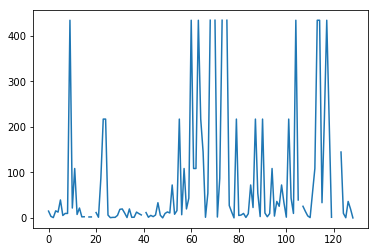

In [201]:
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

cl_weights = sum(lst_values)/(len(np.unique(lst_values))*np.bincount(lst_values))
cl_weights = cl_weights/100

plt.plot(cl_weights)

In [284]:
K = keras.backend

def build_classification_model(embeddings):

    text_input = keras.layers.Input(shape=(None,), dtype='int32')
    embedding_layer = keras.layers.Embedding(input_dim = embeddings.shape[0], 
                                       output_dim = embeddings.shape[1], 
                                       weights=[embeddings],
                                       trainable = False)
    
    x = embedding_layer(text_input)
    x = keras.layers.Bidirectional(keras.layers.LSTM(150, recurrent_dropout=0.25, return_sequences=True))(x)
    

    # Полученный результат направляем в полносвязный слой, который будет осуществлять классификацию
    output_slots = keras.layers.Dense(130, activation='softmax')(x)
    model = keras.models.Model(inputs=[text_input], outputs=[output_slots], name = 'LSTM_classifier')
    
    return model

def my_slots_loss(y_true, y_pred, batch_size = 64):

#     lst_iter = K.arange(start = 0, stop = K.shape(y_true)[0])
#     batch_losses = keras.backend.map_fn(lambda i: ke(y_true[i],y_pred[i]),
#                                      lst_iter, name=None, dtype='float32')
#     losses = K.mean(batch_losses,axis=0)    

    ke = K.sparse_categorical_crossentropy
    losses = ke(K.reshape(y_true,[-1]),K.reshape(y_pred,[-1,130]))
    
    return losses


# ## not finished
def my_accuracy(y_true, y_pred):
    
    class_true = K.flatten(y_true)
    class_pred = K.cast(K.argmax(y_pred, axis=-1),dtype='float32')
    class_pred = K.flatten(class_pred)
    
    uval = tf.unique(class_true)[0]
    
    def my_acc(class_true, class_pred, i_cl):
        
        c1 = K.equal(class_true,i_cl)
        c2 = K.equal(class_pred,i_cl)
        true_pos = K.sum(K.cast(K.all([c1,c2],axis=0),'float32'))
        tot_label = K.sum(K.cast(c1,'float32'))
        acc = (true_pos+K.epsilon())/(tot_label+K.epsilon())
        return acc
        
    acc = keras.backend.map_fn(lambda i: my_acc(class_true, class_pred, i), uval,dtype='float32') 
    return K.mean(acc)

# y_true = K.variable([0,0,0,0,1,3])
# y_pred = K.variable([[0,1],[0,1],[0.88,0.5],[0,1],[0,1],[0,1]])
# tf.keras.backend.eval(acc)



In [285]:
keras.backend.clear_session()
model = build_classification_model(vocab.embeddings)

adam = keras.optimizers.Adam(lr=0.0001)
model.compile(adam, loss = my_slots_loss, metrics=['acc',my_accuracy])


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 50)          20000050  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 300)         241200    
_________________________________________________________________
dense (Dense)                (None, None, 130)         39130     
Total params: 20,280,380
Trainable params: 280,330
Non-trainable params: 20,000,050
_________________________________________________________________


In [286]:
def generate_batches(x, y, batch_size=64):
    i = 0
    while True:
        i = i % len(x)
        yield keras.preprocessing.sequence.pad_sequences(x[i:i+batch_size]), \
              np.expand_dims(keras.preprocessing.sequence.pad_sequences(y[i:i+batch_size],value=129),axis=-1)
        i += batch_size
        
        
x_train, x_val, y_train, y_val = train_test_split(train_sent, train_slots, test_size=0.1)

train_generator = generate_batches(x_train, y_train)
val_generator = generate_batches(x_val, y_val)

steps_per_epoch = int(len(x_train)/64)
steps_per_valid = int(len(x_val)/64)


In [287]:
cbs = [
    keras.callbacks.ModelCheckpoint('models/LSTM/{epoch:02d}-{val_loss:.4f}.h5', save_best_only=True),
    keras.callbacks.TensorBoard(log_dir='models/LSTM/'),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, verbose=1, min_lr=0.00001)
]


model.fit_generator(generator= train_generator, 
                    validation_data = val_generator, 
                    validation_steps= 64, #steps_per_epoch,
                    steps_per_epoch= 256, #steps_per_valid,
                    epochs=5)

Epoch 1/5
256/256 [==============================] - 94s 368ms/step - loss: 1.7838 - acc: 0.0000e+00 - my_accuracy: 0.0375 - val_loss: 0.7467 - val_acc: 0.0000e+00 - val_my_accuracy: 0.0503
Epoch 2/5
256/256 [==============================] - 94s 368ms/step - loss: 0.6680 - acc: 0.0000e+00 - my_accuracy: 0.0640 - val_loss: 0.5389 - val_acc: 0.0000e+00 - val_my_accuracy: 0.0797
Epoch 3/5
256/256 [==============================] - 96s 377ms/step - loss: 0.4875 - acc: 0.0000e+00 - my_accuracy: 0.1005 - val_loss: 0.4077 - val_acc: 0.0000e+00 - val_my_accuracy: 0.1237
Epoch 4/5
256/256 [==============================] - 91s 355ms/step - loss: 0.3781 - acc: 0.0000e+00 - my_accuracy: 0.1526 - val_loss: 0.3301 - val_acc: 0.0000e+00 - val_my_accuracy: 0.1792
Epoch 5/5
256/256 [==============================] - 85s 331ms/step - loss: 0.3054 - acc: 0.0000e+00 - my_accuracy: 0.2273 - val_loss: 0.2729 - val_acc: 0.0000e+00 - val_my_accuracy: 0.2778


In [288]:
## check predicitons
##

x,y  = next(val_generator)
tt = model.predict(x)

#tt = model.predict_generator(val_generator, steps=1)
print (tt.shape)
predictions = [[np.argmax(i) for i in x] for x in tt]
predictions = np.array(predictions)
print (np.unique(predictions))
predictions

(64, 35, 130)
[  2  17  21  26  27  28  33  35  42  48  66  78  83 100 110 119 125 128
 129]


array([[129, 129, 129, ...,  78, 128,   2],
       [129, 119, 128, ..., 128, 128, 128],
       [129, 129, 129, ..., 110, 128,  78],
       ..., 
       [129, 129, 129, ...,  48, 128,  78],
       [129, 129, 129, ..., 128, 128,  78],
       [129, 129, 129, ..., 129,  48, 128]], dtype=int64)

### Combine two models

In [289]:
K = keras.backend

def my_model_two(embeddings):
    # Точка входа в граф задаётся при помощи специальных тензоров типа Input
    # Первая координата соответсвует длине текста, так как тексты в датасете имеют разную длину
    # значение считается переменным
    text_input = keras.layers.Input(shape=(None,), dtype='int32')
    

    embedding_layer = keras.layers.Embedding(input_dim = embeddings.shape[0], 
                                       output_dim = embeddings.shape[1], 
                                       weights=[embeddings],
                                       trainable = False)
    
    x = embedding_layer(text_input)
    x = keras.layers.Bidirectional(keras.layers.GRU(100, recurrent_dropout=0.25, return_sequences=True))(x)

    out1 = keras.layers.Dense(130, activation='softmax', name='output_slots')(x)
    
    x = keras.layers.GRU(100, recurrent_dropout=0.25)(x)

    out2 = keras.layers.Dense(26, activation='softmax', name='output_intents')(x)
    
    model = keras.models.Model(inputs=[text_input], outputs=[out1,out2], name = 'LSTM_classifier')
    
    return model

def my_slots_loss(y_true, y_pred, batch_size = 64):

    lst_iter = K.arange(start = 0, stop =K.shape(y_true)[0])
    ke = K.sparse_categorical_crossentropy
    batch_losses = keras.backend.map_fn(lambda i: ke(y_true[i],y_pred[i]),
                                     lst_iter, name=None, dtype='float32')
    losses = K.mean(batch_losses,axis=0)
    
    return losses


In [290]:
keras.backend.clear_session()
model = my_model_two(vocab.embeddings)

adam = keras.optimizers.Adam(lr=0.0001)

dict_losses = {'output_slots':my_slots_loss, 
               'output_intents':keras.losses.sparse_categorical_crossentropy}
dict_weights = {'output_slots': 1., 'output_intents':1.}


# dict_losses = {'output_intents':keras.losses.sparse_categorical_crossentropy}
# dict_weights = {'output_intents':1.}
# dict_losses = {'output_slots':my_slots_loss}
# dict_weights = {'output_slots': 1.}

model.compile(adam, loss = dict_losses, 
              loss_weights=dict_weights,
              metrics=['acc'])


model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 50)     20000050    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 200)    90600       embedding[0][0]                  
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 100)          90300       bidirectional[0][0]              
__________________________________________________________________________________________________
output_slo

In [665]:
def generate_batches(x, y, y_label, batch_size=64):
    i = 0
    while True:
        i = i % len(x)
        yield keras.preprocessing.sequence.pad_sequences(x[i:i+batch_size]), \
            [np.expand_dims(keras.preprocessing.sequence.pad_sequences(y[i:i+batch_size],value=129),axis=-1),
               np.expand_dims(y_label[i:i+batch_size],axis=-1)]
        i += batch_size
        
        
x_train, x_val, y_train, y_val, y_lab_train, y_lab_val = train_test_split(train_sent, train_slots,train_labels, test_size=0.1)

train_generator = generate_batches(x_train, y_train, y_lab_train)
val_generator = generate_batches(x_val, y_val, y_lab_val)

steps_per_epoch = int(len(x_train)/64)
steps_per_valid = int(len(x_val)/64)

In [666]:
cbs = [
    keras.callbacks.ModelCheckpoint('models/LSTM/{epoch:02d}-{val_loss:.4f}.h5', save_best_only=True),
    keras.callbacks.TensorBoard(log_dir='models/LSTM/'),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, verbose=1, min_lr=0.00001)
]


model.fit_generator(generator= train_generator, 
                    validation_data = val_generator, 
                    validation_steps= 64, #steps_per_epoch,
                    steps_per_epoch= 256, #steps_per_valid,
                    epochs=5)

Epoch 1/5
256/256 [==============================] - 40s 157ms/step - loss: 3.8342 - output_slots_loss: 2.4984 - output_intents_loss: 1.3358 - output_slots_acc: 0.0000e+00 - output_slots_my_accuracy: 914.4746 - output_intents_acc: 0.7104 - output_intents_my_accuracy: 34.7530 - val_loss: 1.8298 - val_output_slots_loss: 0.8787 - val_output_intents_loss: 0.9511 - val_output_slots_acc: 0.0000e+00 - val_output_slots_my_accuracy: 834.1341 - val_output_intents_acc: 0.7643 - val_output_intents_my_accuracy: 32.8419
Epoch 2/5
256/256 [==============================] - 38s 149ms/step - loss: 1.6133 - output_slots_loss: 0.7183 - output_intents_loss: 0.8950 - output_slots_acc: 0.0000e+00 - output_slots_my_accuracy: 909.8668 - output_intents_acc: 0.7781 - output_intents_my_accuracy: 34.7321 - val_loss: 1.3982 - val_output_slots_loss: 0.6396 - val_output_intents_loss: 0.7586 - val_output_slots_acc: 0.0000e+00 - val_output_slots_my_accuracy: 839.7794 - val_output_intents_acc: 0.8051 - val_output_inten

KeyboardInterrupt: 

### Predict test data

In [291]:
atis_test_queries = load_csv('data/atis.test.query.csv')
atis_test_intents = load_csv('data/atis.test.intent.csv')
atis_test_slots = load_csv('data/atis.test.slots.csv')

atis_test_queries = [[int(index) for index in line.split()] for line in atis_test_queries]
atis_test_intents = [int(index) for index in atis_test_intents]
atis_test_slots = [[int(index) for index in line.split()] for line in atis_test_slots]

atis_test_queries_w = [[atis_vocab[i] for i in line] for line in atis_test_queries]

In [292]:
test_sent = [vocab.vectorize(tokens[1:-1]) for tokens in atis_test_queries_w]
test_slots = [i[1:-1] for i in atis_test_slots]
test_labels = atis_test_intents

In [302]:
## Model for intent
##

batch_size = 64
cnt_batches = int(len(test_sent)/batch_size)

test_pred_slots = []
test_pred_intent = []

for i in range(cnt_batches+1):
    i = i * batch_size
    x = keras.preprocessing.sequence.pad_sequences(test_sent[i:i+batch_size])
    y1, y2 = [],[]
#     y1, y2 = model.predict(x)
    tmp1 = [[np.argmax(i) for i in x] for x in y1]
    tmp2 = [np.argmax(x) for x in y2]
    
    test_pred_slots += tmp1
    test_pred_intent += tmp2


In [307]:
from sklearn.metrics import accuracy_score

print ("Final accuracy:", accuracy_score(test_labels,test_pred_intent))

ValueError: Found input variables with inconsistent numbers of samples: [893, 0]